In [2]:
%matplotlib inline

import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import tree
import matplotlib.pyplot as plt
import seaborn as sb

import sqlite3
connection = sqlite3.connect("./database/bdfinal.sql")

In [11]:
columns = "o_fgm,o_fga,o_ftm,o_fta,o_3pm,o_3pa,o_oreb,o_dreb,o_reb,o_asts,o_pf,o_stl,o_to,o_blk,o_pts,d_fgm,d_fga,d_ftm,d_fta,d_3pm,\
    d_3pa,d_oreb,d_dreb,d_reb,d_asts,d_pf,d_stl,d_to,d_blk,d_pts,tmORB,tmDRB,tmTRB,opptmORB,opptmDRB,opptmTRB,won,lost,GP,homeW,homeL,\
        awayW,awayL,confW,confL,firstRound,semis,finals"

query_test = "SELECT playoff, seeded, " + columns + " FROM Teams WHERE year = 10"
query_train = "SELECT playoff, seeded, " + columns + " FROM Teams WHERE year <> 10"

train_data = pd.read_sql(query_train,connection)

categorical_columns = ["firstRound", "semis", "finals"]
for col in categorical_columns:
    train_data[col] = train_data[col].astype('category')

train_data= pd.get_dummies(train_data, columns=categorical_columns)
train_inputs = train_data.loc[:, train_data.columns != "playoff"].values
train_labels = train_data["playoff"].values

test_data = pd.read_sql(query_test,connection)
for col in categorical_columns:
    test_data[col] = test_data[col].astype('category')
test_data = pd.get_dummies(test_data,columns=categorical_columns)
test_inputs = test_data.loc[:, test_data.columns != "playoff"].values
test_labels = test_data["playoff"].values

print(train_data.columns[46])
# print(train_inputs)
# print(train_labels)
# print(test_inputs)
# print(test_labels)


confL


1.0


[Text(0.5, 0.75, 'x[46] <= 0.5\ngini = 0.493\nsamples = 129\nvalue = [57, 72]'),
 Text(0.25, 0.25, 'gini = 0.0\nsamples = 72\nvalue = [0, 72]'),
 Text(0.75, 0.25, 'gini = 0.0\nsamples = 57\nvalue = [57, 0]')]

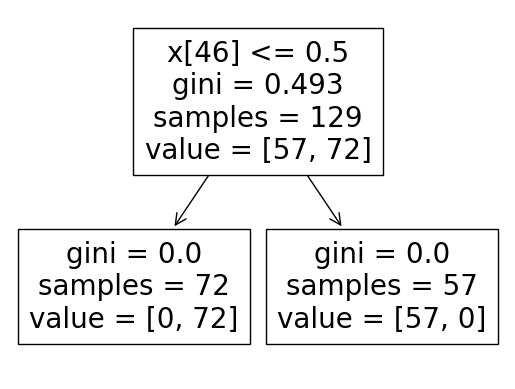

In [10]:
clf = DecisionTreeClassifier(random_state=1)
clf.fit(train_inputs,train_labels)
print(clf.score(test_inputs,test_labels))
tree.plot_tree(clf)

In [16]:
query = "SELECT * FROM Teams"
data = pd.read_sql(query, connection)

sb.pairplot(data, hue='playoff')

KeyboardInterrupt: 